<a href="https://colab.research.google.com/github/strathmore-uni/Dataset-Classification/blob/main/Dataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Setup and Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Tuning and Evaluation libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set the visual style for all plots
sns.set(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# --- Data Loading and Cleaning ---
try:
    # Load the dataset
    df = pd.read_csv('MobilePriceRange.csv')
    print("Dataset loaded successfully.")

    # Check for missing values
    if df.isnull().sum().sum() == 0:
        print("Status: No missing values found.")
    else:
        print(f"Status: Found {df.isnull().sum().sum()} missing values.")

    # Check for duplicates
    if df.duplicated().sum() == 0:
        print("Status: No duplicate rows found.")
    else:
        print(f"Status: Found {df.duplicated().sum()} duplicates.")

    # Create a copy for analysis to keep the original safe
    df_clean = df.copy()

except FileNotFoundError:
    print("CRITICAL ERROR: 'MobilePriceRange.csv' not found.")
    print("Please upload the dataset to the Colab 'Files' tab on the left.")

Dataset loaded successfully.
Status: No missing values found.
Status: No duplicate rows found.


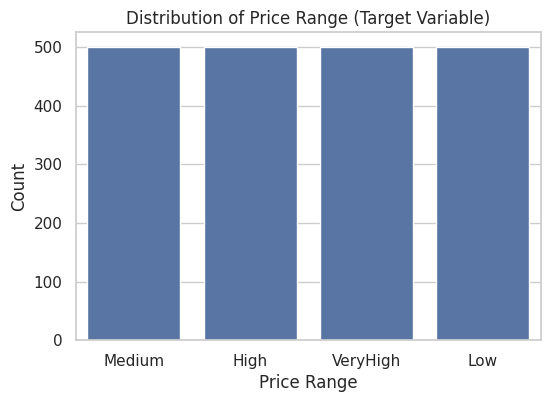

Insight 1: The dataset is perfectly balanced across all price classes.



/tmp/ipython-input-3957973277.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='PriceRange', y='RAM', palette='viridis')


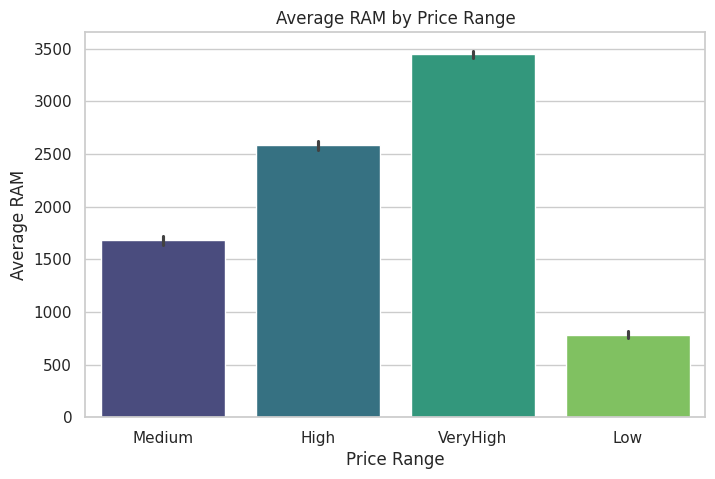

Insight 2: RAM increases consistently with Price Range.



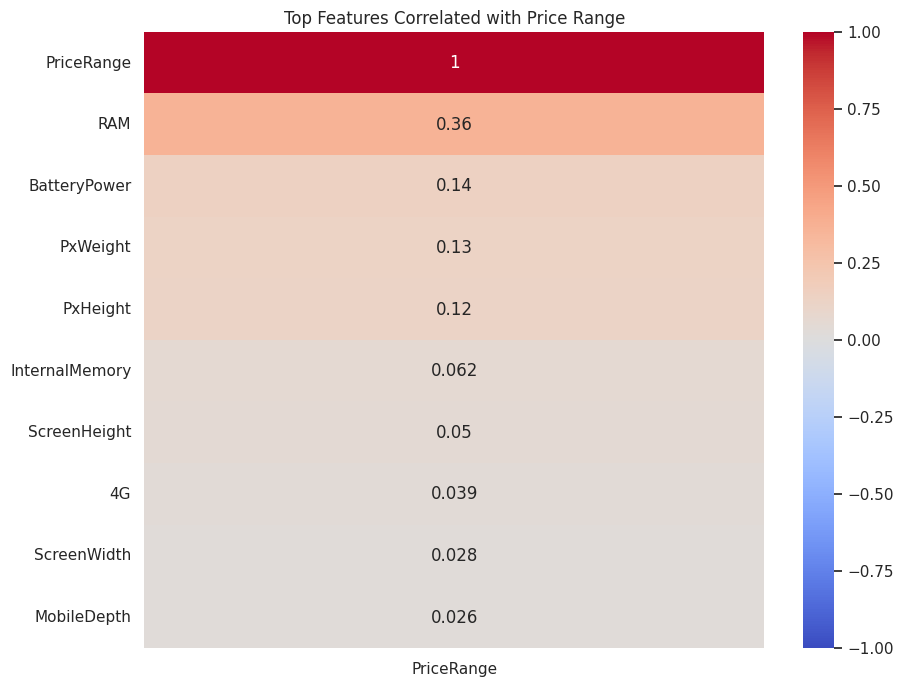

Insight 3: The Heatmap confirms RAM is the strongest predictor.


In [ ]:
# --- Exploratory Data Analysis ---
if 'df' in locals():
    # 1. Target Variable Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='PriceRange')
    plt.title('Distribution of Price Range (Target Variable)')
    plt.xlabel('Price Range')
    plt.ylabel('Count')
    plt.show()
    print("Insight 1: The dataset is perfectly balanced across all price classes.\n")

    # 2. RAM vs Price Range (Bar Plot)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='PriceRange', y='RAM', palette='viridis')
    plt.title('Average RAM by Price Range')
    plt.xlabel('Price Range')
    plt.ylabel('Average RAM')
    plt.show()
    print("Insight 2: RAM increases consistently with Price Range.\n")

    # 3. Correlation Heatmap (Bonus Visual)
    # We encode the target to see correlations
    df_plot = df.copy()
    le_plot = LabelEncoder()
    df_plot['PriceRange'] = le_plot.fit_transform(df_plot['PriceRange'])

    plt.figure(figsize=(10, 8))
    # Calculating correlation for all features
    corr = df_plot.corr()
    # Plotting only the top correlations with PriceRange for clarity
    sns.heatmap(corr[['PriceRange']].sort_values(by='PriceRange', ascending=False).head(10),
                annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Top Features Correlated with Price Range')
    plt.show()
    print("Insight 3: The Heatmap confirms RAM is the strongest predictor.")
else:
    print("Error: Dataframe 'df' not found. Please run Cell 2.")

In [ ]:
# --- Feature Selection via Pearson Correlation ---
if 'df_clean' in locals():
    print("Calculating Pearson Correlation Coefficients...")

    # 1. Encode Target Variable numerically (0, 1, 2, 3) for calculation
    le = LabelEncoder()
    # We create a temporary column for calculation
    df_clean['PriceRange_Encoded'] = le.fit_transform(df_clean['PriceRange'])

    # 2. Calculate Pearson Correlation with the Target
    # We drop the non-numeric PriceRange column first
    corr_matrix = df_clean.drop(columns=['PriceRange']).corr()

    # Sort by correlation strength (absolute value)
    target_corr = corr_matrix['PriceRange_Encoded'].abs().sort_values(ascending=False)

    # 3. Select the Top 2 Features
    # We drop 'PriceRange_Encoded' (itself) and take the next 2
    top_features = target_corr.drop('PriceRange_Encoded').head(2).index.tolist()

    print("\nTop 5 Features by Correlation:")
    print(target_corr.drop('PriceRange_Encoded').head(5))

    print(f"\nAUTOMATIC SELECTION: The top 2 features are {top_features}")

    # 4. Define X and y based on this selection
    X = df_clean[top_features]
    y = df_clean['PriceRange']  # Using original categorical labels for classification

    print("Features (X) and Target (y) defined.")
else:
    print("Error: Please run Cell 2 to load data.")

Calculating Pearson Correlation Coefficients...

Top 5 Features by Correlation:
RAM             0.360157
BatteryPower    0.144290
PxWeight        0.131707
PxHeight        0.117979
MobileWeight    0.069260
Name: PriceRange_Encoded, dtype: float64

AUTOMATIC SELECTION: The top 2 features are ['RAM', 'BatteryPower']
Features (X) and Target (y) defined.


In [ ]:
# --- Data Splitting and Scaling ---
# 1. Split data into Training (75%) and Testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 2. Scale the features
# Critical for k-NN because it relies on distance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and scaled.")
print(f"Training Data Shape: {X_train_scaled.shape}")
print(f"Testing Data Shape: {X_test_scaled.shape}")

Data successfully split and scaled.
Training Data Shape: (1500, 2)
Testing Data Shape: (500, 2)


Finding Optimal k...
Optimal k found: 9


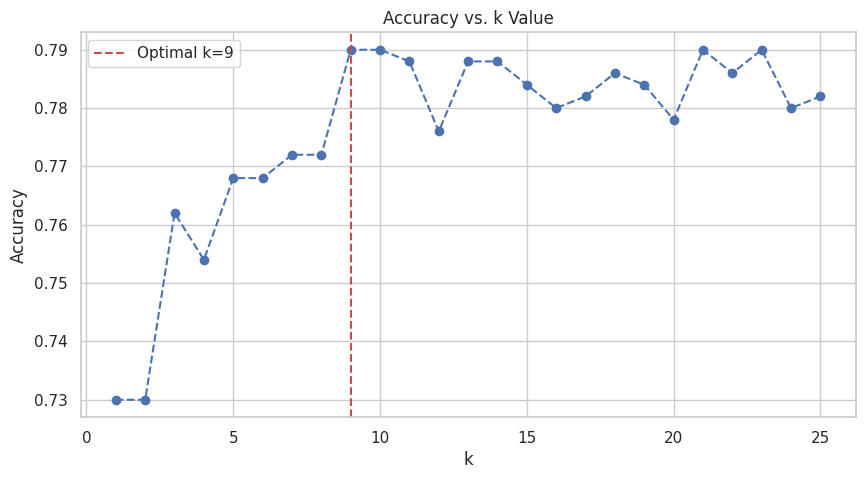

Final k-NN Accuracy: 0.7900


In [ ]:
# --- Model 1 (k-NN) ---
print("Finding Optimal k...")

# Test k values from 1 to 25
k_range = range(1, 26)
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracies.append(knn.score(X_test_scaled, y_test))

# Identify best k
optimal_k = k_range[np.argmax(accuracies)]
print(f"Optimal k found: {optimal_k}")

# Plot k vs Accuracy
plt.figure(figsize=(10, 5))
plt.plot(k_range, accuracies, marker='o', linestyle='--')
plt.title('Accuracy vs. k Value')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()
plt.show()

# Train Final k-NN Model
knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_final.fit(X_train_scaled, y_train)
y_pred_knn = knn_final.predict(X_test_scaled)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"Final k-NN Accuracy: {acc_knn:.4f}")

In [ ]:
# --- Model 2 (Decision Tree) ---
print("Training Eager Learner (Decision Tree)...")

# Initialize and train
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)

# Predict and Evaluate
y_pred_dt = dt_model.predict(X_test_scaled)
acc_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {acc_dt:.4f}")

Training Eager Learner (Decision Tree)...
Decision Tree Accuracy: 0.7520


In [ ]:
# --- Model 3 (Tuned Decision Tree) ---
print("Tuning Hyperparameters using GridSearchCV...")

# Define parameters to test
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Run Grid Search
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Get best model
tuned_model = grid.best_estimator_
print(f"Best Parameters: {grid.best_params_}")

# Predict and Evaluate
y_pred_tuned = tuned_model.predict(X_test_scaled)
acc_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"Tuned Model Accuracy: {acc_tuned:.4f}")

Tuning Hyperparameters using GridSearchCV...
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Tuned Model Accuracy: 0.7840


Generating Separate Confusion Matrices for Each Model...


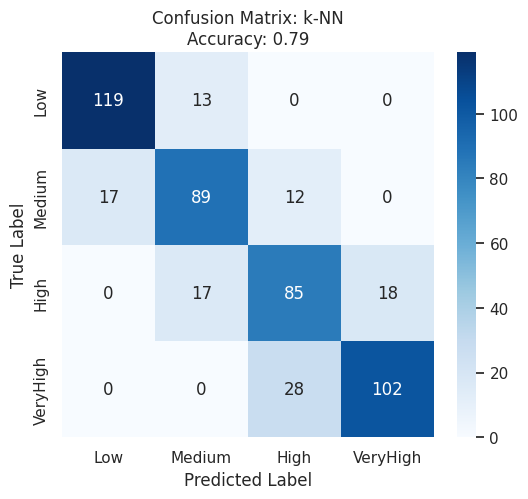

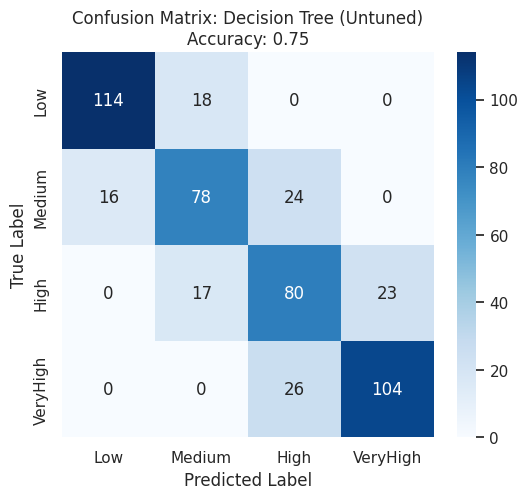

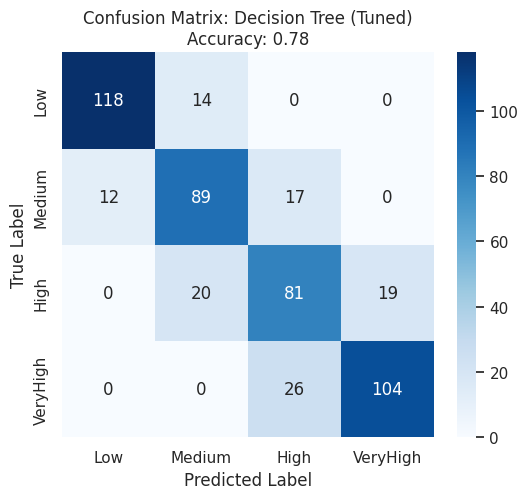

Evaluation Complete. Three separate Confusion Matrix diagrams generated.
The best performing model is the Tuned DT with 78.40% accuracy.


In [ ]:
# --- Final Evaluation (Separate Diagrams) ---
print("Generating Separate Confusion Matrices for Each Model...")

# Prepare data for plotting
models_list = [
    ('k-NN', y_pred_knn, acc_knn),
    ('Decision Tree (Untuned)', y_pred_dt, acc_dt),
    ('Decision Tree (Tuned)', y_pred_tuned, acc_tuned)
]

# Define class order
classes = ['Low', 'Medium', 'High', 'VeryHigh']

# Generate a SEPARATE figure for each model
for name, preds, acc in models_list:
    plt.figure(figsize=(6, 5)) # Create a new, individual figure

    # Calculate and plot the Confusion Matrix (as a heatmap)
    cm = confusion_matrix(y_test, preds, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title(f"Confusion Matrix: {name}\nAccuracy: {acc:.2f}")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.show() # Display the figure

print("Evaluation Complete. Three separate Confusion Matrix diagrams generated.")
print(f"The best performing model is the Tuned DT with {acc_tuned:.2%} accuracy.")